In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATA_PATH = r"DATASET/feature_time_48k_2048_load_1.csv"

df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
print(df.head())
print(df.info())


Shape: (2300, 10)
       max      min      mean        sd       rms  skewness  kurtosis  \
0  0.35986 -0.41890  0.017840  0.122746  0.124006 -0.118571 -0.042219   
1  0.46772 -0.36111  0.022255  0.132488  0.134312  0.174699 -0.081548   
2  0.46855 -0.43809  0.020470  0.149651  0.151008  0.040339 -0.274069   
3  0.58475 -0.54303  0.020960  0.157067  0.158422 -0.023266  0.134692   
4  0.44685 -0.57891  0.022167  0.138189  0.139922 -0.081534  0.402783   

      crest      form       fault  
0  2.901946  6.950855  Ball_007_1  
1  3.482334  6.035202  Ball_007_1  
2  3.102819  7.376926  Ball_007_1  
3  3.691097  7.558387  Ball_007_1  
4  3.193561  6.312085  Ball_007_1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2300 entries, 0 to 2299
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   max       2300 non-null   float64
 1   min       2300 non-null   float64
 2   mean      2300 non-null   float64
 3   sd        2300 non-n

In [2]:
feature_cols = ["max", "min", "mean", "sd", "rms",
                "skewness", "kurtosis", "crest", "form"]

# Numerical summary
summary = df[feature_cols].describe().T
print(summary)


           count       mean        std       min       25%        50%  \
max       2300.0   1.575079   1.578422  0.157300  0.456398   0.794510   
min       2300.0  -1.550994   1.602706 -6.292600 -2.174975  -0.733700   
mean      2300.0   0.015711   0.006469  0.003246  0.011236   0.013730   
sd        2300.0   0.341601   0.305279  0.059140  0.135506   0.188551   
rms       2300.0   0.342289   0.304813  0.061067  0.136374   0.190662   
skewness  2300.0  -0.042251   0.180774 -1.089928 -0.103426  -0.002466   
kurtosis  2300.0   2.664444   4.411096 -0.803795 -0.015164   0.816970   
crest     2300.0   4.173130   1.148349  2.428511  3.260382   3.921650   
form      2300.0  26.544769  29.209702  3.484429  7.413359  13.122811   

                75%         max  
max        2.278425    6.825900  
min       -0.426987   -0.160220  
mean       0.018638    0.038386  
sd         0.555589    1.256577  
rms        0.555671    1.256311  
skewness   0.061093    1.059512  
kurtosis   3.902286   30.385326

In [3]:
# Binary label: healthy vs faulty
df["is_faulty"] = (df["fault"] != "Normal_1").astype(int)

def parse_fault_label(label):
    """
    Parse strings like:
    - 'Normal_1'
    - 'Ball_007_1'
    - 'IR_014_1'
    - 'OR_021_6_1'
    and return a dict with interpreted info.
    """
    parts = label.split("_")

    if parts[0] == "Normal":
        return {
            "fault_type": "Normal",
            "defect_size_inch": 0.0,
            "outer_race_position": np.nan,
            "load_hp": int(parts[1])
        }

    if parts[0] == "OR":
        # OR_<size>_<position>_<load>
        return {
            "fault_type": "OuterRace",
            "defect_size_inch": float(parts[1]) / 1000.0,  # 007 -> 0.007"
            "outer_race_position": int(parts[2]),         # 6 o'clock, etc.
            "load_hp": int(parts[3])
        }

    # Ball or Inner Race
    if parts[0] == "Ball":
        ftype = "Ball"
    elif parts[0] == "IR":
        ftype = "InnerRace"
    else:
        ftype = parts[0]  # fallback

    # e.g. Ball_007_1 or IR_014_1
    return {
        "fault_type": ftype,
        "defect_size_inch": float(parts[1]) / 1000.0,
        "outer_race_position": np.nan,
        "load_hp": int(parts[2])
    }

parsed = df["fault"].apply(parse_fault_label).apply(pd.Series)
df = pd.concat([df, parsed], axis=1)

df[["fault", "fault_type", "defect_size_inch", "outer_race_position", "load_hp"]].drop_duplicates()


,fault,fault_type,defect_size_inch,outer_race_position,load_hp
0,Ball_007_1,Ball,0.007,NaN,1
230,Ball_014_1,Ball,0.014,NaN,1
460,Ball_021_1,Ball,0.021,NaN,1
690,IR_007_1,InnerRace,0.007,NaN,1
920,IR_014_1,InnerRace,0.014,NaN,1
1150,IR_021_1,InnerRace,0.021,NaN,1
1380,OR_007_6_1,OuterRace,0.007,6.0,1
1610,OR_014_6_1,OuterRace,0.014,6.0,1
1840,OR_021_6_1,OuterRace,0.021,6.0,1
2070,Normal_1,Normal,0.000,NaN,1


In [4]:
print("Healthy vs faulty:")
print(df["is_faulty"].value_counts())
print(df["is_faulty"].value_counts(normalize=True))

print("\nFault types:")
print(df["fault_type"].value_counts())

print("\nOriginal labels:")
print(df["fault"].value_counts())


Healthy vs faulty:
is_faulty
1    2070
0     230
Name: count, dtype: int64
is_faulty
1    0.9
0    0.1
Name: proportion, dtype: float64

Fault types:
fault_type
Ball         690
InnerRace    690
OuterRace    690
Normal       230
Name: count, dtype: int64

Original labels:
fault
Ball_007_1    230
Ball_014_1    230
Ball_021_1    230
IR_007_1      230
IR_014_1      230
IR_021_1      230
OR_007_6_1    230
OR_014_6_1    230
OR_021_6_1    230
Normal_1      230
Name: count, dtype: int64


In [5]:
group_stats = df.groupby("is_faulty")[feature_cols].agg(["mean", "std"])
print(group_stats)


                max                 min                mean            \
               mean       std      mean       std      mean       std   
is_faulty                                                               
0          0.205093  0.019011 -0.206493  0.021997  0.012488  0.002528   
1          1.727299  1.592643 -1.700383  1.621999  0.016069  0.006671   

                 sd                 rms            skewness            \
               mean       std      mean       std      mean       std   
is_faulty                                                               
0          0.065046  0.002318  0.066265  0.002334 -0.173084  0.077607   
1          0.372330  0.306769  0.372959  0.306313 -0.027714  0.183115   

           kurtosis               crest                 form             
               mean       std      mean       std       mean        std  
is_faulty                                                                
0         -0.095627  0.158080  3.093996  0.252

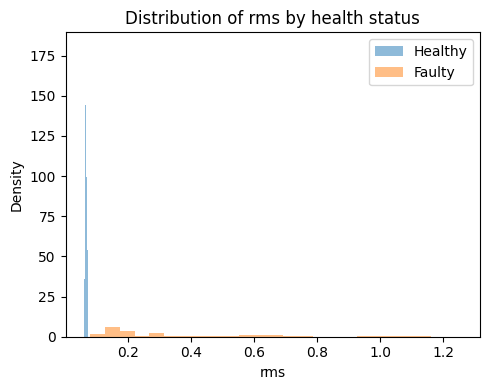

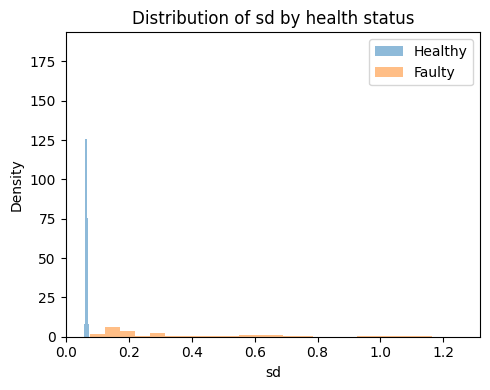

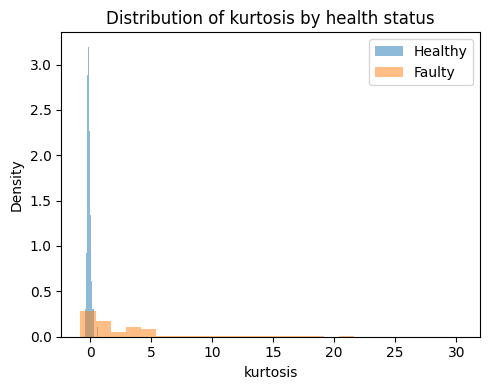

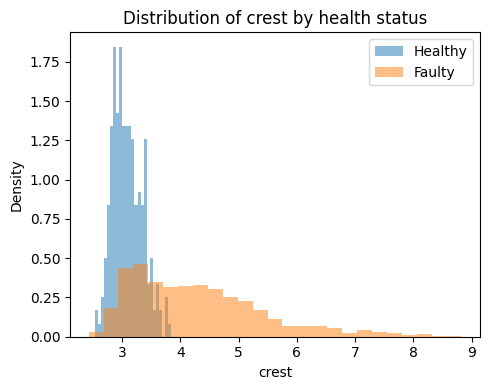

In [6]:
feature_to_plot = ["rms", "sd", "kurtosis", "crest"]

for col in feature_to_plot:
    plt.figure(figsize=(5,4))
    for val, subset in df.groupby("is_faulty"):
        label = "Faulty" if val == 1 else "Healthy"
        plt.hist(subset[col], bins=25, alpha=0.5, density=True, label=label)
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.title(f"Distribution of {col} by health status")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [7]:
from scipy import stats

healthy_rms = df.loc[df["is_faulty"] == 0, "rms"].values
faulty_rms  = df.loc[df["is_faulty"] == 1, "rms"].values

len(healthy_rms), len(faulty_rms)


(230, 2070)

In [8]:
# D'Agostino and Pearson test for normality
k2_h, p_h = stats.normaltest(healthy_rms)
k2_f, p_f = stats.normaltest(faulty_rms)

print("Healthy RMS normality test:  statistic =", k2_h, ", p-value =", p_h)
print("Faulty  RMS normality test:  statistic =", k2_f, ", p-value =", p_f)


Healthy RMS normality test:  statistic = 3.082297409249007 , p-value = 0.21413498225054398
Faulty  RMS normality test:  statistic = 335.77008573036863 , p-value = 1.2258922220106227e-73


In [15]:
# Levene's test for equality of variances (robust to non-normality)
stat_lev, p_lev = stats.levene(healthy_rms, faulty_rms, center="mean")
print("Levene test for equal variances: statistic =", stat_lev, ", p-value =", p_lev)


Levene test for equal variances: statistic = 532.1193955102791 , p-value = 4.475230151042296e-106


In [16]:
def mean_confidence_interval(x, confidence=0.95):
    x = np.asarray(x)
    n = len(x)
    mean = np.mean(x)
    s = np.std(x, ddof=1)
    alpha = 1 - confidence
    # t critical value with n-1 degrees of freedom
    t_crit = stats.t.ppf(1 - alpha/2, df=n-1)
    half_width = t_crit * s / np.sqrt(n)
    return mean, mean - half_width, mean + half_width

mean_h, ci_h_low, ci_h_high = mean_confidence_interval(healthy_rms)
mean_f, ci_f_low, ci_f_high = mean_confidence_interval(faulty_rms)

print("Healthy RMS: mean = {:.4f}, 95% CI = [{:.4f}, {:.4f}]".format(
    mean_h, ci_h_low, ci_h_high))
print("Faulty  RMS: mean = {:.4f}, 95% CI = [{:.4f}, {:.4f}]".format(
    mean_f, ci_f_low, ci_f_high))


Healthy RMS: mean = 0.0663, 95% CI = [0.0660, 0.0666]
Faulty  RMS: mean = 0.3730, 95% CI = [0.3598, 0.3862]


In [17]:
t_stat, p_two_sided = stats.ttest_ind(
    faulty_rms,
    healthy_rms,
    equal_var=False  # Welch's t-test
)

print("Welch t-test (faulty vs healthy, RMS)")
print("t-statistic =", t_stat)
print("two-sided p-value =", p_two_sided)

# If you want the one-sided p-value for H1: mean_faulty > mean_healthy
if t_stat > 0:
    p_one_sided = p_two_sided / 2
else:
    p_one_sided = 1 - p_two_sided / 2

print("one-sided p-value (mean_faulty > mean_healthy) =", p_one_sided)


Welch t-test (faulty vs healthy, RMS)
t-statistic = 45.541785021955484
two-sided p-value = 2.1842316603e-314
one-sided p-value (mean_faulty > mean_healthy) = 1.09211583e-314


In [18]:
def cohens_d(x1, x2):
    x1 = np.asarray(x1)
    x2 = np.asarray(x2)
    n1, n2 = len(x1), len(x2)
    s1 = np.var(x1, ddof=1)
    s2 = np.var(x2, ddof=1)
    # pooled standard deviation
    s_pooled = np.sqrt(((n1 - 1)*s1 + (n2 - 1)*s2) / (n1 + n2 - 2))
    d = (np.mean(x1) - np.mean(x2)) / s_pooled
    return d

d_rms = cohens_d(faulty_rms, healthy_rms)
print("Cohen's d (RMS, faulty vs healthy) =", d_rms)


Cohen's d (RMS, faulty vs healthy) = 1.055192377955504
